## Predicting Diabetes ML

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
# Load data
data = pd.read_csv("diabetes_prediction_dataset.csv")

# Clean column names
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')

# Convert target to numeric
data['diabetes'] = pd.to_numeric(data['diabetes'], errors='coerce')

# Handle missing values
data['bmi'] = data['bmi'].fillna(data['bmi'].median())
data['hba1c_level'] = data['hba1c_level'].fillna(data['hba1c_level'].median())
data['blood_glucose_level'] = data['blood_glucose_level'].fillna(data['blood_glucose_level'].median())

# Encode categorical features
data = pd.get_dummies(data, columns=['gender', 'smoking_history'], drop_first=True)

# Define features and target
X = data.drop(columns=['diabetes'])  # Features
y = data['diabetes']  # Target variable

In [4]:
# Test Each Feature Individually
feature_scores = {}

for feature in X.columns:
    X_single = X[[feature]]  # Select only one feature

# Split Data
    X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.2, random_state=46)

    # Standardize Data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train a Random Forest model
    model = RandomForestClassifier(random_state=46)
    model.fit(X_train, y_train)

    # Predict & Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

# Store result
    feature_scores[feature] = accuracy

# Convert results to a sorted DataFrame
feature_accuracy_df = pd.DataFrame.from_dict(feature_scores, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False)
print("Feature Accuracy Scores:")
print(feature_accuracy_df)

Feature Accuracy Scores:
                             Accuracy
hba1c_level                   0.95415
blood_glucose_level           0.94650
age                           0.91415
hypertension                  0.91415
heart_disease                 0.91415
gender_Male                   0.91415
gender_Other                  0.91415
smoking_history_current       0.91415
smoking_history_ever          0.91415
smoking_history_former        0.91415
smoking_history_never         0.91415
smoking_history_not current   0.91415
bmi                           0.90985



Feature Importance Rankings from Random Forest Classifier:
                        Feature  Importance
4                   hba1c_level    0.404336
5           blood_glucose_level    0.327744
3                           bmi    0.120628
0                           age    0.098792
1                  hypertension    0.012648
2                 heart_disease    0.011641
6                   gender_Male    0.006339
11        smoking_history_never    0.004874
10       smoking_history_former    0.004311
8       smoking_history_current    0.003309
12  smoking_history_not current    0.002805
9          smoking_history_ever    0.002571
7                  gender_Other    0.000001


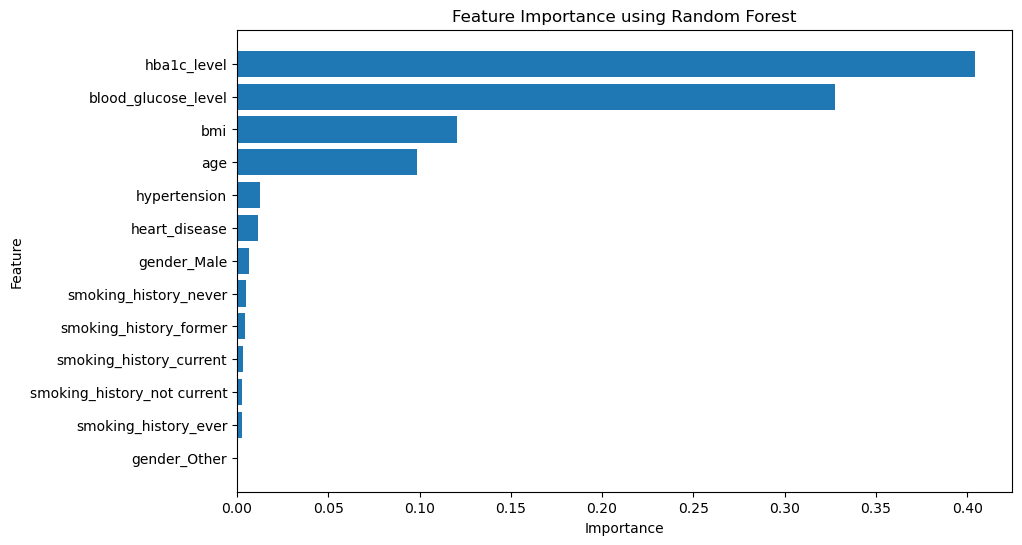

In [5]:
# Train Full Model & Extract Feature Importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

# Standardize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46)
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance Rankings from Random Forest Classifier:")
print(feature_importance_df)

# Visualizing Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance using Random Forest")
plt.gca().invert_yaxis()
plt.show()

In [6]:
from imblearn.over_sampling import SMOTE

# FULL Model (Using All Features)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

X_full = data.drop(columns=['diabetes'])
y = data['diabetes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=46)

# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest
clf_full = RandomForestClassifier(n_estimators=50, random_state=46)
clf_full.fit(X_train, y_train)
y_pred_full = clf_full.predict(X_test)

# Initialize classifiers dictionary
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=46)
}

# Train and predict for each model
y_preds = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)  # Train the model
    y_preds[name] = clf.predict(X_test)  # Predict on test set

# Compute classification report & confusion matrix
for name, y_pred in y_preds.items():
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n📌 Full Model (All Features)")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_full))
    print("Classification Report:\n", classification_report(y_test, y_pred_full))
    
# ROC Curve for Full Model
y_prob_full = clf_full.predict_proba(X_test)[:, 1]
fpr_full, tpr_full, thresholds = roc_curve(y_test, y_prob_full)
auc_full = auc(fpr_full, tpr_full)


# LIMITED Model (Only HbA1c_level and blood_glucose_level)
X_limited = data[['hba1c_level', 'blood_glucose_level']]

# Split data
X_train_limited, X_test_limited, y_train_limited, y_test_limited = train_test_split(X_limited, y, test_size=0.2, random_state=46)

# Standardizing features
scaler = StandardScaler()
X_train_limited = scaler.fit_transform(X_train_limited)
X_test_limited = scaler.transform(X_test_limited)

# Train Random Forest
clf_limited = RandomForestClassifier(n_estimators=50, random_state=46)
clf_limited.fit(X_train_limited, y_train_limited)
y_pred_limited = clf_limited.predict(X_test_limited)

# Compute evaluation metrics for limited model
print("\n📌 Limited Model (HbA1c level & blood glucose level)")
print("Confusion Matrix:\n", confusion_matrix(y_test_limited, y_pred_limited))
print("Classification Report:\n", classification_report(y_test_limited, y_pred_limited))

# Compute ROC curve
y_prob_limited = clf_limited.predict_proba(X_test_limited)[:, 1]  # Get probability estimates for the positive class (diabetes)
fpr_limited, tpr_limited, thresholds = roc_curve(y_test, y_prob_limited)
auc_limited = auc(fpr_limited, tpr_limited)

# SMOTE dataset 
X_smote = data.drop(columns=['diabetes'])
y = data['diabetes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)

# Apply SMOTE to only the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

clf_smote = RandomForestClassifier(n_estimators=50, random_state=46)
clf_smote.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_smote = clf_smote.predict(X_test)

# Compute evaluation metrics for limited model
print("\n📌 SMOTE Model (all features)")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

# Compute ROC curve
y_prob_smote = clf_smote.predict_proba(X_test)[:, 1]  # Get probability estimates for the positive class (diabetes)
fpr_smote, tpr_smote, thresholds = roc_curve(y_test, y_prob_smote)
auc_smote = auc(fpr_smote, tpr_smote)

Training Random Forest...

📌 Full Model (All Features)
Confusion Matrix:
 [[18221    62]
 [  543  1174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18283
           1       0.95      0.68      0.80      1717

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000


📌 Limited Model (HbA1c level & blood glucose level)
Confusion Matrix:
 [[18283     0]
 [  576  1141]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18283
           1       1.00      0.66      0.80      1717

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000


📌 SMOTE Model (all features)
Confusion Matrix:
 [[17965   335]
 [  447  1253]]
Classifica